# Jake's exploration

In [145]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import json
import ast
import nltk

In [146]:
df = pd.read_csv("ted_main.csv")
print df.dtypes
print df.shape

comments               int64
description           object
duration               int64
event                 object
film_date              int64
languages              int64
main_speaker          object
name                  object
num_speaker            int64
published_date         int64
ratings               object
related_talks         object
speaker_occupation    object
tags                  object
title                 object
url                   object
views                  int64
dtype: object
(2550, 17)


In [147]:
# fix some errors in the df
for idx, row in df.iterrows():
    if row.title.startswith('Why I believe the mistreatment of women'):
        df.at[idx, 'title'] = 'Why I believe the mistreatment of women is the number one human rights abuse'
    if row.title.startswith('A forensic anthropologist who bri'):
        df.at[idx, 'title'] = 'A forensic anthropologist who brings closure for the "disappeared"'

### Do the average number of views from related videos affect views on the video?

In [148]:
related_view = []
for idx, row in df.iterrows():
    view_m = re.findall('\'viewed_count\': [0-9]+', row.related_talks)
    total_views = 0
    num_related_vids = 0
    for v in view_m:
        vs = re.search('[0-9]+', v)
        num_related_vids += 1
        total_views += int(vs.group(0))
    related_view.append(total_views / num_related_vids)
df['avg_related_views'] = pd.Series(data=related_view, index=df.index)

print df.dtypes

comments               int64
description           object
duration               int64
event                 object
film_date              int64
languages              int64
main_speaker          object
name                  object
num_speaker            int64
published_date         int64
ratings               object
related_talks         object
speaker_occupation    object
tags                  object
title                 object
url                   object
views                  int64
avg_related_views      int64
dtype: object


#### Let's look at the distribution of views

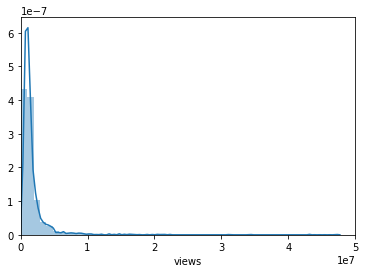

In [149]:
plt.xlim(0, 50000000)
sns.distplot(df.views)
plt.savefig('images/views_with_outliers.png')

#### There seem to be a lot of high outliers. Let's get rid of those...

In [150]:
q1_related = df["avg_related_views"].quantile(0.25)
q3_related = df["avg_related_views"].quantile(0.75)
q1 = df["views"].quantile(0.25)
q3 = df["views"].quantile(0.75)
no_outliers = [row.avg_related_views if row.avg_related_views < q3_related + (q3_related - q1_related) * 1.5 else np.nan for idx, row in df.iterrows()]
xaxis = [row.views if row.views < q3 + (q3 - q1) * 1.5 else np.nan for idx, row in df.iterrows()]
xaxis = [xaxis[idx] if not np.isnan(no_outliers[idx]) else np.nan for idx, row in df.iterrows()]
no_outliers = [no_outliers[idx] if not np.isnan(xaxis[idx]) else np.nan for idx, row in df.iterrows()]

for i in range(len(no_outliers)-1, -1, -1):
    if np.isnan(no_outliers[i]):
        no_outliers.pop(i)
        xaxis.pop(i)

for i in range(len(xaxis)-1, -1, -1):
    if np.isnan(xaxis[i]):
        no_outliers.pop(i)
        xaxis.pop(i)

no_outliers = pd.Series(data=no_outliers)
xaxis = pd.Series(data=xaxis)

line_kws={'color':'r', 'lw':1}
scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.3}



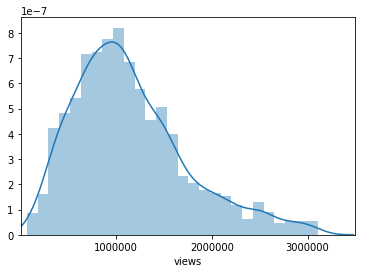

In [151]:
plt.xlim(0, 3500000)
plt.xticks([1e6, 2e6, 3e6])
sns.distplot(xaxis, axlabel="views")
plt.savefig('images/views_with_no_outliers.png')

#### This is roughly normal, but still skewed right.
#### Let's look at the distribution of the average related view count

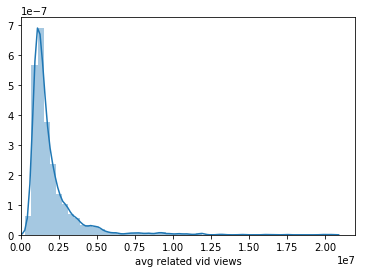

In [152]:
plt.xlim(0, 22000000)
sns.distplot(df.avg_related_views, axlabel="avg related vid views")
plt.savefig('images/avg_related_vid_views_outliers.png')

#### This also seems to have a lot of high outliers

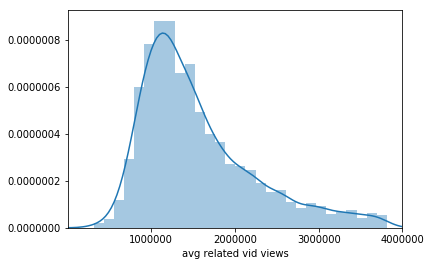

In [153]:
plt.xlim(0, 4000000)
plt.xticks([1000000, 2000000, 3000000, 4000000])
sns.distplot(no_outliers, axlabel="avg related vid views")
plt.savefig('images/avg_related_vid_views_no_outliers.png')

#### This is also slightly skewed right, and looks very similar to the view distribution without outliers
#### Let's see if there is a correlation between view count and the average number of related views

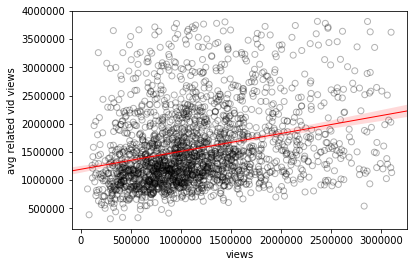

In [154]:
ax = sns.regplot(x=xaxis , y=no_outliers, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='avg related vid views')
plt.savefig('images/views_vs_avg_related_vid_views.png')
plt.show()

#### Maybe of order 2?

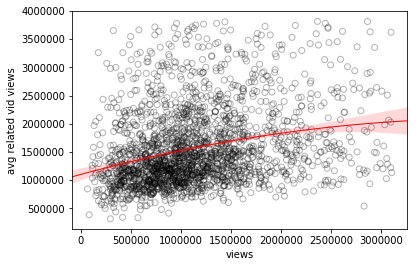

In [155]:
ax = sns.regplot(x=xaxis , y=no_outliers, order=2, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='avg related vid views')
plt.savefig('images/views_vs_avg_related_vid_views_order_2.png')
plt.show()

#### not different enough to matter. Let's look at the residuals for the linear regression and the slope and $R^2$ scores

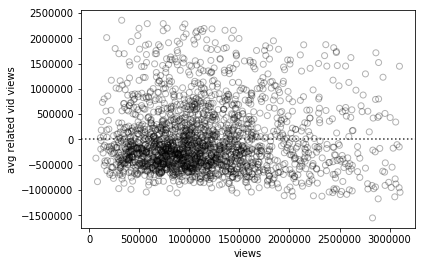

In [156]:
ax = sns.residplot(x=xaxis, y=no_outliers, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='avg related vid views')
plt.savefig('images/views_vs_avg_related_vid_views_residuals.png')
plt.show()

In [157]:
X = xaxis.reshape(-1, 1)
regr = LinearRegression()
regr.fit(X, no_outliers)
y_pred = regr.predict(X)

print "slope = {0:.11f}".format(regr.coef_[0])
print "R^2   = {0:.5f}".format(r2_score(no_outliers, y_pred))

slope = 0.31726970833
R^2   = 0.07791


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


#### In short, there is a positive linear correlation between video views and the number of views on related videos, but it is a weak one.

### Create undirected Graph

In [158]:
undirected_graph = []

for idx, row in df.iterrows():
    for talk in ast.literal_eval(row.related_talks):
        i0 = talk['title']
        i1 = row.title
        # check if extra quotations were added, problem in dataset
        if i0 == '"Awoo"' or i1 == '"Awoo"' or \
                i0 == '"Women of Hope"' or i1 == '"Women of Hope"' \
                or i0 == '"Tembererana"' or i1 == '"Tembererana"' or \
                i0 == '"Redemption Song"' or i1 == '"Redemption Song"' or \
                i0 == '"Put the financial aid in the bag"' or i1 == '"Put the financial aid in the bag"' or \
                i0 == '"Black Men Ski"' or i1 == '"Black Men Ski"' or \
                i0 == '"M\'Bifo"' or i1 == '"M\'Bifo"' or \
                i0 == '"Clonie"' or i1 == '"Clonie"' or \
                i0 == '"Peace on Earth"' or i1 == '"Peace on Earth"' or \
                i0 == '"High School Training Ground"' or i1 == '"High School Training Ground"' or \
                i0 == '"The Sacred Art of the Ori"' or i1 == '"The Sacred Art of the Ori"' or \
                i0 == '"The Dog Song"' or i1 == '"The Dog Song"' or \
                i0 == '"Woza"' or i1 == '"Woza"' or \
                i0 == '"La Vie en Rose"' or i1 == '"La Vie en Rose"' or \
                i0 == '"Wait It Out"' or i1 == '"Wait It Out"' or \
                i0 == '"What You\'ve Got"' or i1 == '"What You\'ve Got"' or \
                i0 == '"Space Oddity"' or i1 == '"Space Oddity"' or \
                i0 == '"Thula Mama"' or i1 == '"Thula Mama"' or \
                i0 == '"Music for Wood and Strings"' or i1 == '"Music for Wood and Strings"' or \
                i0 == '"Kiteflyer\'s Hill"' or i1 == '"Kiteflyer\'s Hill"' or \
                i0 == '"Turceasca"' or i1 == '"Turceasca"' or \
                i0 == '"(Nothing But) Flowers" with string quartet' or i1 == '"(Nothing But) Flowers" with string quartet' or \
                i0 == '"St. James Infirmary Blues"' or i1 == '"St. James Infirmary Blues"' or \
                i0 == '"Love Is a Loaded Pistol"' or i1 == '"Love Is a Loaded Pistol"' or \
                i0 == '"Mother of Pearl," "If I Had You"' or i1 == '"Mother of Pearl," "If I Had You"' or \
                i0 == '"Rollercoaster"' or i1 == '"Rollercoaster"' or \
                i0 == '"Family Tree"' or i1 == '"Family Tree"':
            pass
        elif i0.startswith('Why I believe the mistreatment of women'):
            i0 = "Why I believe the mistreatment of women is the number one human rights abuse"
        elif i1.startswith('Why I believe the mistreatment of women'):
            i1 = "Why I believe the mistreatment of women is the number one human rights abuse"
        elif i0.startswith('A forensic anthropologist who brin'):
            i0 = 'A forensic anthropologist who brings closure for the "disappeared"'
        elif i1.startswith('A forensic anthropologist who brin'):
            i1 = 'A forensic anthropologist who brings closure for the "disappeared"'
        elif i0[0] == '"':
            i0 = i0[1:len(i0) - 1]
        elif i1[0] == '"':
            i1 = i1[1:len(i1) - 1]
        undirected_graph.append(sorted([i0, i1]))

undirected_graph = list(set(map(tuple,undirected_graph)))

### add column of number of related videos

In [159]:
related_vid_nums = []

for idx, row in df.iterrows():
    total = 0
    for edge in undirected_graph:
        if edge[0] == row.title or edge[1] == row.title:
            total += 1
    related_vid_nums.append(total)

### How do the number of related videos affect view counts?

In [160]:
# add num_related_vids feature
df['num_related_vids'] = pd.Series(data=related_vid_nums)

q1_views = df['views'].quantile(0.25)
q3_views = df['views'].quantile(0.75)
q1_num_related_vids = df['num_related_vids'].quantile(0.25)
q3_num_related_vids = df['num_related_vids'].quantile(0.75)

views_no_outliers = [row.views if row.views < q3_views + (q3_views - q1_views) * 1.5 else np.nan for idx, row in df.iterrows()]
num_related_vids_no_outliers = [row.num_related_vids if row.num_related_vids < q3_num_related_vids + (q3_num_related_vids - q1_num_related_vids) * 1.5 else np.nan for idx, row in df.iterrows()]
num_related_vids_no_outliers = [num_related_vids_no_outliers[idx] if not np.isnan(views_no_outliers[idx]) else np.nan for idx, row in df.iterrows()]
views_no_outliers = [views_no_outliers[idx] if not np.isnan(num_related_vids_no_outliers[idx]) else np.nan for idx, row in df.iterrows()]

for i in range(len(views_no_outliers)-1, -1, -1):
    if np.isnan(views_no_outliers[i]):
        views_no_outliers.pop(i)
        num_related_vids_no_outliers.pop(i)

for i in range(len(num_related_vids_no_outliers)-1, -1, -1):
    if np.isnan(num_related_vids_no_outliers[i]):
        num_related_vids_no_outliers.pop(i)
        views_no_outliers.pop(i)

views_no_outliers = pd.Series(data=views_no_outliers)
num_related_vids_no_outliers = pd.Series(data=num_related_vids_no_outliers)


#### distributions

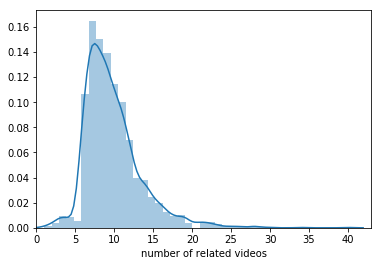

In [161]:
plt.xlim(0, 43)
sns.distplot(df.num_related_vids, bins=41, axlabel='number of related videos')
plt.savefig('images/num_related_vids_outliers.png')

#### No outliers

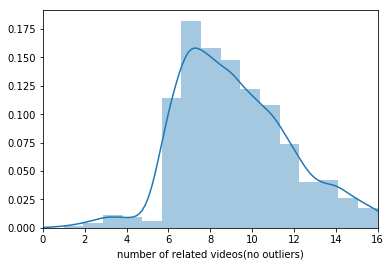

In [162]:
plt.xlim(0, 16)
sns.distplot(num_related_vids_no_outliers, bins=16, axlabel='number of related videos(no outliers)')
plt.savefig('images/num_related_vids_no_outliers.png')

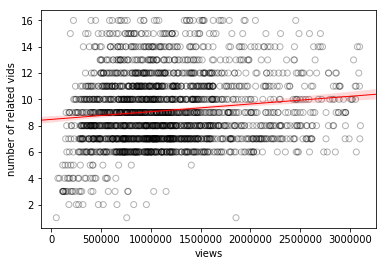

In [163]:
ax = sns.regplot(x=views_no_outliers , y=num_related_vids_no_outliers, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='number of related vids')
plt.savefig('images/views_vs_num_related_vids.png')
plt.show()

In [164]:
X = views_no_outliers.values.reshape(-1, 1)
regr = LinearRegression()
regr.fit(X, num_related_vids_no_outliers)
y_pred = regr.predict(X)

print "slope = {0:.11f}".format(regr.coef_[0])
print "R^2   = {0:.5f}".format(r2_score(num_related_vids_no_outliers, y_pred))

slope = 0.00000058533
R^2   = 0.01775


### What about a reanalysis of views vs avg num related views based on the undirected graph.

In [165]:
# get title:view pairs
title_view_dict = {}
for idx, row in df.iterrows():
    title_view_dict[row.title] = row.views

# dict for related views of each vid
rel_view_dict = {}
# add a key for each vid
for idx, row in df.iterrows():
    rel_view_dict[row.title] = []
# for each vertex in the graph, add the view count of each vid attached by an edge
for edge in undirected_graph:
    rel_view_dict[edge[0]].append(title_view_dict[edge[1]])
    rel_view_dict[edge[1]].append(title_view_dict[edge[0]])
# done?

#### Turn the dict values into the mean of the lists

In [166]:
for x in rel_view_dict:
    tempsum = 0
    for y in rel_view_dict[x]:
        tempsum += y
    rel_view_dict[x] = tempsum / len(rel_view_dict[x])
new_related_views = []
for idx, row in df.iterrows():
    new_related_views.append(rel_view_dict[row.title])
new_related_views = pd.Series(data=new_related_views)

#### Now let's look at the distribution

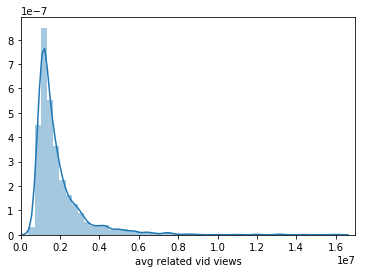

In [167]:
plt.xlim(0, 17000000)
sns.distplot(new_related_views, axlabel='avg related vid views')
plt.savefig('images/num_related_vids_with_outliers_new.png')

#### and now remove the outliers

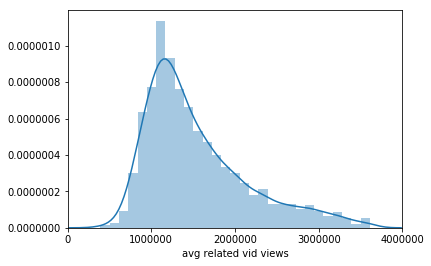

In [168]:
q1_views = df['views'].quantile(0.25)
q3_views = df['views'].quantile(0.75)
q1_related = new_related_views.quantile(0.25)
q3_related = new_related_views.quantile(0.75)

views_no_outliers = [row.views if row.views < q3_views + (q3_views - q1_views) * 1.5 else np.nan for idx, row in df.iterrows()]
related_views_no_outliers = [x if x < q3_related + (q3_related - q1_related) * 1.5 else np.nan for x in new_related_views]
related_views_no_outliers = [related_views_no_outliers[i] if not np.isnan(views_no_outliers[i]) else np.nan for i in range(len(related_views_no_outliers))]
views_no_outliers = [views_no_outliers[i] if not np.isnan(related_views_no_outliers[i]) else np.nan for i in range(len(related_views_no_outliers))]

for i in range(len(views_no_outliers)-1, -1, -1):
    if np.isnan(views_no_outliers[i]):
        views_no_outliers.pop(i)
        related_views_no_outliers.pop(i)

for i in range(len(related_views_no_outliers)-1, -1, -1):
    if np.isnan(related_views_no_outliers[i]):
        related_views_no_outliers.pop(i)
        views_no_outliers.pop(i)
        
views_no_outliers = pd.Series(data=views_no_outliers)
related_views_no_outliers = pd.Series(data=related_views_no_outliers)

plt.xlim(0, 4000000)
plt.xticks([0, 1000000, 2000000, 3000000, 4000000])
sns.distplot(related_views_no_outliers, axlabel='avg related vid views')
plt.savefig('images/num_related_vids_no_outliers_new.png')

#### Now a regression

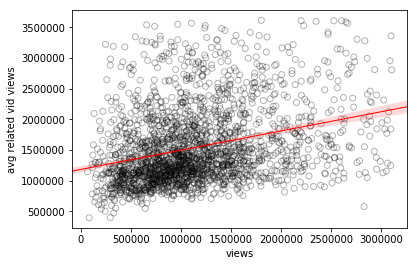

In [169]:
ax = sns.regplot(x=views_no_outliers , y=related_views_no_outliers, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set(xlabel='views', ylabel='avg related vid views')
plt.savefig('images/views_vs_avg_related_vid_views_new.png')
plt.show()

In [170]:
X = views_no_outliers.values.reshape(-1, 1)
regr = LinearRegression()
regr.fit(X, related_views_no_outliers)
y_pred = regr.predict(X)

print "slope = {0:.11f}".format(regr.coef_[0])
print "R^2   = {0:.5f}".format(r2_score(related_views_no_outliers, y_pred))

slope = 0.31340769511
R^2   = 0.09367


# PART II - ML

### Let's find the maximal cliques from the undirected graph of videos

In [171]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(undirected_graph)
cliques = list(nx.find_cliques(G))

### Visualization of the undirected graph

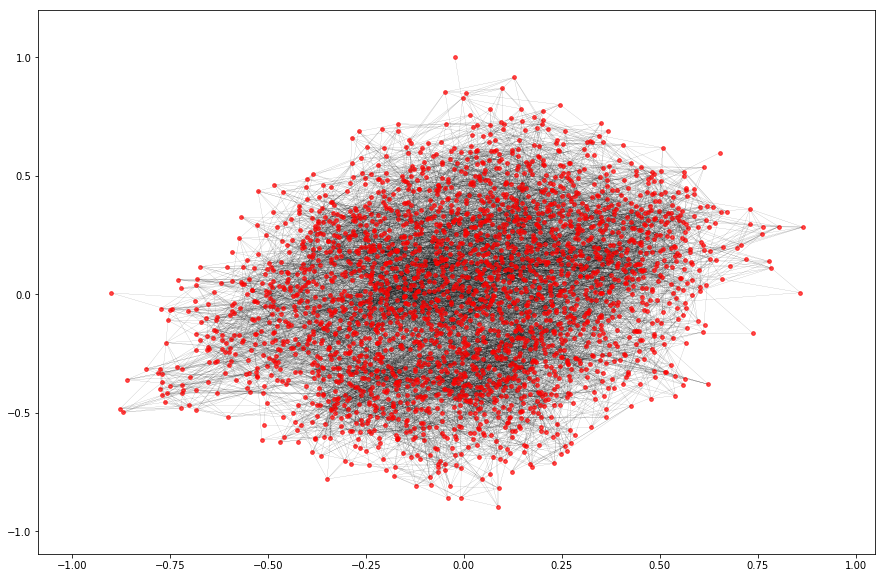

In [172]:
fig, ax = plt.subplots(figsize=(15,10))

graph_pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, graph_pos, node_size=14, node_color='red', alpha=0.7)
nx.draw_networkx_edges(G, graph_pos, width=.08)

plt.show()

#### Let's get some info about the cliques

In [173]:
print 'number of maximal cliques: ' + str(len(cliques))
print 'average number of videos per macimal clique: ' + str(float(sum([len(x) for x in cliques])) / len(cliques))
print 'highest number of videos in a maximal clique: ' + str(max([len(x) for x in cliques]))
print 'lowest number of videos in a maximal clique: ' + str(min([len(x) for x in cliques]))

number of maximal cliques: 7239
average number of videos per macimal clique: 2.6861444951
highest number of videos in a maximal clique: 7
lowest number of videos in a maximal clique: 2


#### Distribution of maximal clique size

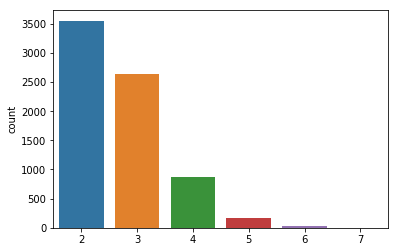

In [174]:
clique_sizes = [len(x) for x in cliques]
sns.countplot(pd.Series(data=clique_sizes))

# Does language matter? (Sentiment analysis)

### Q1 Let's look at the transcripts of the videos and see if we can find words that may have influenced view counts to see if certain language make viewers respond better or worse.

In [175]:
# label view outliers
q1 = df["views"].quantile(0.25)
q3 = df["views"].quantile(0.75)
df.loc[df['views'] > q3 + (q3 - q1) * 1.5, 'outlier'] = 1
df.loc[df['views'] <= q3 + (q3 - q1) * 1.5, 'outlier'] = 0

In [176]:
# import transcripts
df_trans = pd.read_csv("transcripts.csv")
print df_trans.dtypes
print df_trans.shape

transcript    object
url           object
dtype: object
(2467, 2)


In [177]:
# add transcripts from df_trans to df (videos that do not have transcripts have None in the column transcript)

# get transcripts in order
# make dict from df_trans where [key:url, value:transcript]
url_transcript_dict = {}
for idx, row in df_trans.iterrows():
    url_transcript_dict[(row.url)[0:len(row.url)-2]] = row.transcript  # also getting rid of newline characters

    
transcripts_in_order = []

for idx, row in df.iterrows():
    transcripts_in_order.append((row.url)[0: len(row.url)-1])
        
for i in range(len(transcripts_in_order)):
    try:
        transcripts_in_order[i] = url_transcript_dict[transcripts_in_order[i]]
    except KeyError:
        transcripts_in_order[i] = ''
        
        
df['transcript'] = pd.Series(data=transcripts_in_order)
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,related_talks,speaker_occupation,tags,title,url,views,avg_related_views,num_related_vids,outlier,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,"[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,3027062,30,1.0,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,"[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,1118767,18,1.0,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,"[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,1846195,10,0.0,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,"[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,776189,23,0.0,If you're here today — and I'm very happy that...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,"[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,1907337,23,1.0,"About 10 years ago, I took on the task to teac..."


In [178]:
from sklearn.feature_extraction.text import CountVectorizer

# get vocab

count_vect = CountVectorizer()
count_vect.fit_transform(df['transcript'])

vocab = count_vect.vocabulary_

print "the size of vocab is {0}.".format(len(vocab))

the size of vocab is 58795.


In [179]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# lowercase the text, remove stop words, remove words with length smaller than 3 characters, stem

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def filter_words(review):
    """
    Return a pre-processed review string
    
    Parameters:
    ------------
    review: (original) review text, string
    
    Returns:
    -------------
    fitered: a filtered string
    """

    # lower case
    step1 = review.decode('utf-8').lower()
    word_tokens = word_tokenize(step1)
    # no stop words
    step2 = [w for w in word_tokens if not w in stop_words]
    # no words shorter than 3 characters
    step3 = [w for w in step2 if len(w) >= 3]
    # stemmed
    try:
        step4 = [ps.stem(w) for w in step3]
    except UnicodeDecodeError:
        print review
        return
    filtered = ''
    for w in step4:
        filtered += ' ' + w
    
    return filtered

df['transcript_filtered'] = df['transcript'].apply(filter_words)

df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,speaker_occupation,tags,title,url,views,avg_related_views,num_related_vids,outlier,transcript,transcript_filtered
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,3027062,30,1.0,Good morning. How are you?(Laughter)It's been ...,good morn laughter great n't 've blown away w...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,1118767,18,1.0,"Thank you so much, Chris. And it's truly a gre...",thank much chri truli great honor opportun co...
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,1846195,10,0.0,"(Music: ""The Sound of Silence,"" Simon & Garfun...",music sound silenc simon garfunkel hello voic...
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,776189,23,0.0,If you're here today — and I'm very happy that...,'re today happi 've heard sustain develop sav...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,1907337,23,1.0,"About 10 years ago, I took on the task to teac...",year ago took task teach global develop swedi...


In [180]:
count_vect = CountVectorizer()
count_vect.fit_transform(df['transcript_filtered'])

vocab = count_vect.vocabulary_

print "The size of vocabulary V (after the pre-processing) is {0}.".format(len(vocab))

The size of vocabulary V (after the pre-processing) is 43163.


In [181]:
from nltk.probability import FreqDist

# get the 2k most frequent words

def build_vocabulary(topk=2000):
    """
    build a vocabulary using the top k most frequent words
    
    Parameters:
    -------------
    topk: int, the number of top k frequent words to include into the vocabulary
    
    Returns:
    ---------
    vocab: a dictionary (key=word, value=index)
    """
    
    # will contain every transcript
    all_transcripts = ''
    for idx, row in df.iterrows():
        all_transcripts += row.transcript_filtered + ' '
        
        
    # get most frequent words
    words = word_tokenize(all_transcripts)
    fdist = FreqDist(words)
    most_common = fdist.most_common(topk)
    
    # put into dict
    vocab = {}
    for i in range(len(most_common)):
        vocab[most_common[i][0]] = i
    
    return vocab

vocab = build_vocabulary()

In [182]:
# decide if a video has a high amount of views or not

median = df["views"].quantile(0.5)
df.loc[df['views'] > median, 'above_median'] = 1
df.loc[df['views'] <= median, 'above_median'] = 0

# build feature vectors

count_vect = CountVectorizer(vocabulary=vocab)
X = count_vect.fit_transform(df['transcript_filtered'])
y = df.as_matrix(['above_median']).ravel()

print "X.shape=", X.shape
print "y.shape=", y.shape

X.shape= (2550, 2000)
y.shape= (2550L,)


In [183]:
# train test split

from sklearn.model_selection import train_test_split

# number of examples to use for training
n_train = 2000

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]

In [184]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# get training test accuracies

# Bayes
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes_train = bayes.score(X_train, y_train)
bayes_test = bayes.score(X_test, y_test)

# Logistic regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
logistic_train = logistic.score(X_train, y_train)
logistic_test = logistic.score(X_test, y_test)

print 'BASED ON MEDIAN'
print 'Naive bayes, train accuracy=', bayes_train
print 'Naive bayes, test accuracy=', bayes_test
print 'Logistic regression, train accuracy', logistic_train
print 'Logistic regression, test accuracy', logistic_test

BASED ON MEDIAN
Naive bayes, train accuracy= 0.7205
Naive bayes, test accuracy= 0.618181818182
Logistic regression, train accuracy 0.995
Logistic regression, test accuracy 0.587272727273


### It looks like naive Bayes will be the better option here with a surprising 61.5% testing accuracy!

### How about running based on outliers?

In [185]:
# build feature vectors

count_vect = CountVectorizer(vocabulary=vocab)
X = count_vect.fit_transform(df['transcript_filtered'])
y = df.as_matrix(['outlier']).ravel()

print "X.shape=", X.shape
print "y.shape=", y.shape

X.shape= (2550, 2000)
y.shape= (2550L,)


In [186]:
# train test split

# number of examples to use for training
n_train = 2000

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]

In [187]:
# get training test accuracies

# Bayes
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes_train = bayes.score(X_train, y_train)
bayes_test = bayes.score(X_test, y_test)

# Logistic regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
logistic_train = logistic.score(X_train, y_train)
logistic_test = logistic.score(X_test, y_test)

print 'BASED ON OUTLIER'
print 'Naive bayes, train accuracy=', bayes_train
print 'Naive bayes, test accuracy=', bayes_test
print 'Logistic regression, train accuracy', logistic_train
print 'Logistic regression, test accuracy', logistic_test

BASED ON OUTLIER
Naive bayes, train accuracy= 0.7905
Naive bayes, test accuracy= 0.707272727273
Logistic regression, train accuracy 0.999
Logistic regression, test accuracy 0.874545454545


### strangely high... try 50% train

In [188]:
# train test split

# number of examples to use for training
n_train = 1275

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]

In [189]:
# get training test accuracies

# Bayes
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes_train = bayes.score(X_train, y_train)
bayes_test = bayes.score(X_test, y_test)

# Logistic regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
logistic_train = logistic.score(X_train, y_train)
logistic_test = logistic.score(X_test, y_test)

print 'BASED ON OUTLIER with 50% training data'
print 'Naive bayes, train accuracy=', bayes_train
print 'Naive bayes, test accuracy=', bayes_test
print 'Logistic regression, train accuracy', logistic_train
print 'Logistic regression, test accuracy', logistic_test

BASED ON OUTLIER with 50% training data
Naive bayes, train accuracy= 0.82431372549
Naive bayes, test accuracy= 0.738823529412
Logistic regression, train accuracy 0.998431372549
Logistic regression, test accuracy 0.869019607843


### Q2 what words are important?

In [190]:
# add word counts as columns in df

for x in vocab:
    v = []
    for idx, row in df.iterrows():
        cnt = 0
        flag = True
        start = 0
        while flag:
            a = row.transcript.decode('utf-8').find(x, start)
            if a == -1:
                flag = False
            else:
                cnt += 1
                start = a + 1
        v.append(cnt)
        
    df['vocab_' + x] = pd.Series(data=v)

In [191]:
from sklearn.linear_model import LinearRegression

# regress on each word in vocab

coefs = []
vocab_list = []
for x in vocab:
    regr = LinearRegression()
    regr.fit(df[['views']], df['vocab_' + x])
    coefs.append(regr.coef_[0])
    vocab_list.append(x)

In [192]:
# find word with most influence

coefs, vocab_list = (list(t) for t in zip(*sorted(zip(coefs, vocab_list))))

print 'worst words:\n', vocab_list[:20]
print '\nbest words:\n', vocab_list[-20:]

worst words:
[u'net', u'build', u'tie', u'technolog', u'water', u'unit', u'govern', u'design', u'plan', u'hous', u'gene', u'global', u'citi', u'land', u'cell', u'count', u'ocean', u'elect', u'fish', u'place']

best words:
[u'think', u'know', u'per', u'want', u'use', u'ear', u'like', u'ant', u'said', u"'re", u'aid', u'peopl', u'thing', u'one', u'go', u'ad', u'hey', u"n't", u'be', u'.']


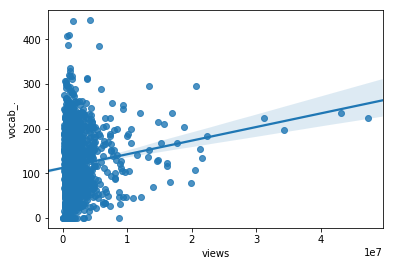

In [193]:
# plot the best fit

sns.regplot(x=df['views'], y=df['vocab_.'])

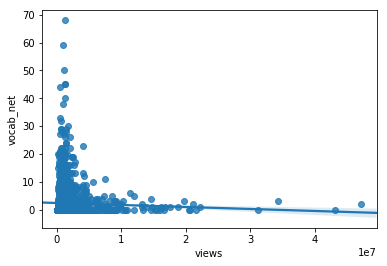

In [194]:
# plot the worst fit

sns.regplot(x=df['views'], y=df['vocab_net'])

## What about no outliers??

In [195]:
# regress on each word in vocab
#df.loc[df['views'] > median, 'above_median'] = 1

coefs = []
vocab_list = []
for x in vocab:
    regr = LinearRegression()
    regr.fit(df.query('outlier == 0')[['views']] , df.query('outlier == 0')['vocab_' + x])
    coefs.append(regr.coef_[0])
    vocab_list.append(x)

In [196]:
# find word with most influence

coefs, vocab_list = (list(t) for t in zip(*sorted(zip(coefs, vocab_list))))

print 'worst words:\n', vocab_list[:20]
print '\nbest words:\n', vocab_list[-20:]

worst words:
[u'sea', u'cancer', u'water', u'ocean', u'heal', u'govern', u'health', u'land', u'oil', u'passion', u'fish', u'build', u'citi', u'area', u'unit', u'dollar', u'need', u'polic', u'enter', u'compass']

best words:
[u'time', u'think', u'peopl', u'other', u'ant', u'ever', u'use', u'act', u'like', u'man', u'thing', u'ear', u'one', u'ad', u'per', u"n't", u'hey', u'lo', u'be', u'.']


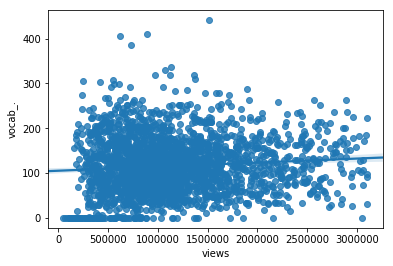

In [197]:
# plot the best fit

sns.regplot(x=df.query('outlier == 0')['views'], y=df.query('outlier == 0')['vocab_.'])

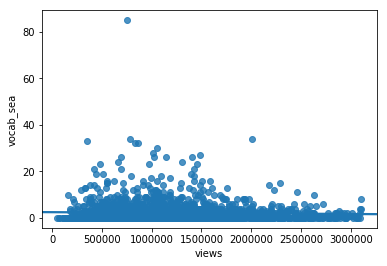

In [198]:
# plot the worst fit

sns.regplot(x=df.query('outlier == 0')['views'], y=df.query('outlier == 0')['vocab_sea'])

## What if we ignore zero values for word counts?

In [199]:
# regress on each word in vocab
#df.loc[df['views'] > median, 'above_median'] = 1

coefs = []
vocab_list = []
for x in vocab:
    try:
        regr = LinearRegression()
        regr.fit((df.query('outlier == 0')[df['vocab_' + x] > 0])[['views']] , (df.query('outlier == 0')[df['vocab_' + x] > 0])['vocab_' + x])
        coefs.append(regr.coef_[0])
        vocab_list.append(x)
    except ValueError:
        pass

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [200]:
# find word with most influence

coefs, vocab_list = (list(t) for t in zip(*sorted(zip(coefs, vocab_list))))

print 'worst words:\n', vocab_list[:20]
print '\nbest words:\n', vocab_list[-20:]

worst words:
[u'mosquito', u'vaccin', u'cancer', u'compass', u'shark', u'ocean', u'viru', u'blog', u'reef', u'patent', u'tumor', u'fish', u'surgeri', u'coral', u'film', u'congress', u'bread', u'passion', u'cartoon', u'laptop']

best words:
[u'brain', u'articl', u'prime', u'inequ', u'sexual', u'be', u'religi', u'consciou', u'conscious', u'quantum', u'sex', u'cooper', u'balloon', u'particl', u'laugh', u'bacteria', u'religion', u'dinosaur', u'laughter', u'autism']


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


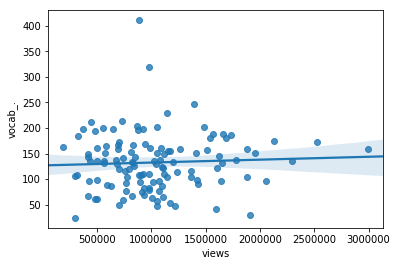

In [201]:
# plot the best fit

sns.regplot(x=(df.query('outlier == 0')[df['vocab_' + x] > 0])['views'], y=(df.query('outlier == 0')[df['vocab_' + x] > 0])['vocab_.'])

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


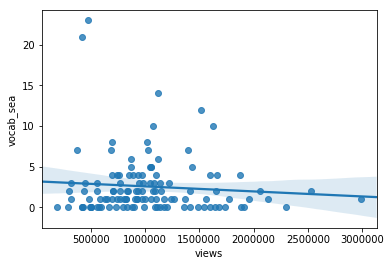

In [202]:
# plot the worst fit

sns.regplot(x=(df.query('outlier == 0')[df['vocab_' + x] > 0])['views'], y=(df.query('outlier == 0')[df['vocab_' + x] > 0])['vocab_sea'])

## Based on bayes (median)

In [203]:
# build feature vectors

count_vect = CountVectorizer(vocabulary=vocab)
X = count_vect.fit_transform(df['transcript_filtered'])
y = df.as_matrix(['above_median']).ravel()

print "X.shape=", X.shape
print "y.shape=", y.shape

X.shape= (2550, 2000)
y.shape= (2550L,)


In [204]:
# train test split

# number of examples to use for training
n_train = 2000

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]

In [205]:
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
coefs = bayes.coef_
vocab_list = [x for x in vocab]

coefs, vocab_list = (list(t) for t in zip(*sorted(zip(coefs, vocab_list))))

print 'worst words:\n', vocab_list[:20]
print '\nbest words:\n', vocab_list[-20:]

worst words:
[u'yellow']

best words:
[u'yellow']


## Based on Bayes (outlier)

In [206]:
# build feature vectors

count_vect = CountVectorizer(vocabulary=vocab)
X = count_vect.fit_transform(df['transcript_filtered'])
y = df.as_matrix(['outlier']).ravel()

print "X.shape=", X.shape
print "y.shape=", y.shape

X.shape= (2550, 2000)
y.shape= (2550L,)


In [207]:
# train test split

# number of examples to use for training
n_train = 2000

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]

In [208]:
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
coefs = bayes.coef_
vocab_list = [x for x in vocab]

coefs, vocab_list = (list(t) for t in zip(*sorted(zip(coefs, vocab_list))))

print 'worst words:\n', vocab_list[:20]
print '\nbest words:\n', vocab_list[-20:]

worst words:
[u'yellow']

best words:
[u'yellow']


### Q4 What about video titles? Sentiment analysis

In [209]:
# get vocab

count_vect = CountVectorizer()
count_vect.fit_transform(df['title'])

vocab = count_vect.vocabulary_

print "the size of vocab is {0}.".format(len(vocab))

the size of vocab is 3658.


In [210]:
# filter

df['title_filtered'] = df['title'].apply(filter_words)
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,vocab_repeat,vocab_star,vocab_stay,vocab_accomplish,vocab_experienc,vocab_scientif,vocab_rule,vocab_emerg,vocab_rural,title_filtered
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,0,3,0,0,3,0,0,0,0,school kill creativ
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,1,4,1,1,0,0,0,0,0,avert climat crisi
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,0,4,1,0,0,0,2,0,0,simplic sell
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,0,0,0,0,1,0,0,2,0,green ghetto
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,0,6,0,0,0,0,0,0,0,best stat 've ever seen


In [211]:
# get vocab count

count_vect = CountVectorizer()
count_vect.fit_transform(df['title_filtered'])

vocab = count_vect.vocabulary_

print "The size of vocabulary V (after the pre-processing) is {0}.".format(len(vocab))

The size of vocabulary V (after the pre-processing) is 2792.


In [212]:
# build vocab
# get the 2k most frequent words

def build_vocabulary(topk=2000):
    """
    build a vocabulary using the top k most frequent words
    
    Parameters:
    -------------
    topk: int, the number of top k frequent words to include into the vocabulary
    
    Returns:
    ---------
    vocab: a dictionary (key=word, value=index)
    """
    
    # will contain every title
    all_titles = ''
    for idx, row in df.iterrows():
        all_titles += row.title_filtered + ' '
        
        
    # get most frequent words
    words = word_tokenize(all_titles)
    fdist = FreqDist(words)
    most_common = fdist.most_common(topk)
    
    # put into dict
    vocab = {}
    for i in range(len(most_common)):
        vocab[most_common[i][0]] = i
    
    return vocab

vocab = build_vocabulary()

In [213]:
# build feature vectors

count_vect = CountVectorizer(vocabulary=vocab)
X = count_vect.fit_transform(df['title_filtered'])
y = df.as_matrix(['above_median']).ravel()

print "X.shape=", X.shape
print "y.shape=", y.shape

X.shape= (2550, 2000)
y.shape= (2550L,)


In [214]:
# train test split
# number of examples to use for training
n_train = 2000

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]

In [215]:
# get training test accuracies

# Bayes
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes_train = bayes.score(X_train, y_train)
bayes_test = bayes.score(X_test, y_test)

# Logistic regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
logistic_train = logistic.score(X_train, y_train)
logistic_test = logistic.score(X_test, y_test)

print 'BASED ON MEDIAN'
print 'Naive bayes, train accuracy=', bayes_train
print 'Naive bayes, test accuracy=', bayes_test
print 'Logistic regression, train accuracy', logistic_train
print 'Logistic regression, test accuracy', logistic_test

BASED ON MEDIAN
Naive bayes, train accuracy= 0.8475
Naive bayes, test accuracy= 0.603636363636
Logistic regression, train accuracy 0.872
Logistic regression, test accuracy 0.596363636364
